In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from Config import Config 


In [2]:
min_date = pd.to_datetime("2020-08-15")
max_date = pd.to_datetime("2021-04-01")

In [11]:
# Read data 
# political prisoners data 
prisoners_f = "../processed_data/viasna_data/viasna_political_prisoners.csv"
prisoners = pd.read_csv(prisoners_f)
prisoners.date_of_detention = pd.to_datetime(prisoners.date_of_detention)

# An incident means detention (including at the border), drawing up a report, search, etc.
incedents_f = "../processed_data/viasna_data/persecutionDatabase.csv"
incedents = pd.read_csv(incedents_f)
incedents.date_of_incident = pd.to_datetime(incedents.date_of_incident)


In [12]:
incedents.date_of_incident.min(), incedents.date_of_incident.max()

(Timestamp('2020-08-09 00:00:00'), Timestamp('2021-04-01 00:00:00'))

In [13]:
incedents.head(2)

,Unnamed: 0,No,date_of_incident,name,gender,article,court_date,judge,court,arrest,penalty,additionally,district_translated,region_translated
0,0,1220,2021-04-01,Агееў Юрый,м,24.23 ч.1 КаАП – «парушэньне парадку арганізац...,2021-04-01,NaN,Магілёў,7 сут.,"25 б.в. 725,00 руб.",NaN,Mogilev,Mogilev
1,1,1221,2021-04-01,Гаўрыс Вольга,ж,24.23 ч.1 КаАП – «парушэньне парадку арганізац...,2021-04-02,Новікава Е.С.,"Менск, раённы",NaN,"30 б.в. 870,00 руб.",За чырвоныя сардэчкі на вокнах,Minsk,Minsk


In [14]:
# number of incidents across regions
incedents.region_translated.value_counts()

Minsk      18416
Brest       1400
Mogilev      861
Grodno       849
Gomel        712
Vitebsk      580
Name: region_translated, dtype: int64

In [15]:
# number of incidents across the top 20 districts
incedents.district_translated.value_counts()[:20]

Minsk             16097
Smalyavichy        1607
Brest               755
Mogilev             567
Grodno              564
Gomel               387
Vitebsk             291
Maladzyechna        281
Baranovichy         205
Polotsk             136
Babruysk            125
Barysaw             123
Kastsyukovichy      114
Salihorsk           114
Mazyr               100
Pinsk                87
Svietlahorsk         75
Orsha                71
Zhlobin              67
Baranavichy          65
Name: district_translated, dtype: int64

In [18]:
district_incedents = incedents.groupby(["district_translated", "date_of_incident"])["name"].count().reset_index(drop=False)
district_incedents.rename(columns={"name": "repression_count"}, inplace=True)

In [19]:
district_incedents.to_csv("../processed_data/viasna_data/incidents_data.csv", index=False)


In [24]:
prisoners.date_of_detention.min(), prisoners.date_of_detention.max()

Timestamp('2009-02-08 00:00:00')

In [27]:
# Daily number of prisoners
daily_num_prisoners = (
    prisoners
    .groupby("date_of_detention")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_detention": "date" ,"name": "num_prisoners"})
    )

# Daily number of incidents
daily_num_incedents = (
    incedents
    .groupby("date_of_incident")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_incident": "date","name": "num_incidents"})
    )

In [28]:
# add any missing days between min/max to the dataset
all_days = pd.date_range(min_date, max_date, freq='D')

# check for missing days and fill the num_detentions column with 0 
daily_num_prisoners = ( 
    daily_num_prisoners
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

# check for missing days and fill the num_detentions column with 0 
daily_num_incedents = ( 
    daily_num_incedents
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

In [29]:
# merge prisoners and incidents
df_merge = daily_num_prisoners.merge(daily_num_incedents, how="left", on="date")

In [30]:
# Day of week 
df_merge["day_of_week"] = df_merge.date.dt.day_name()

In [31]:
df_merge.head(10)

,date,num_prisoners,num_incidents,day_of_week
0,2020-08-15,2.0,8.0,Saturday
1,2020-08-16,0.0,10.0,Sunday
2,2020-08-17,1.0,10.0,Monday
3,2020-08-18,5.0,2.0,Tuesday
4,2020-08-19,5.0,5.0,Wednesday
5,2020-08-20,1.0,8.0,Thursday
6,2020-08-21,0.0,5.0,Friday
7,2020-08-22,2.0,13.0,Saturday
8,2020-08-23,0.0,41.0,Sunday
9,2020-08-24,0.0,30.0,Monday


<AxesSubplot:>

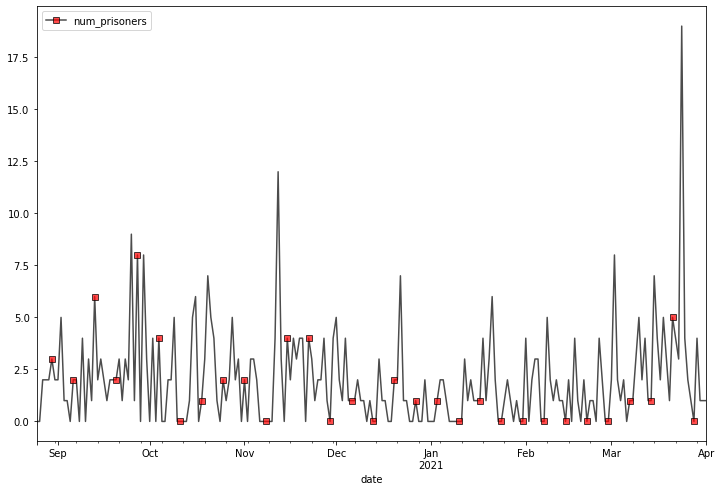

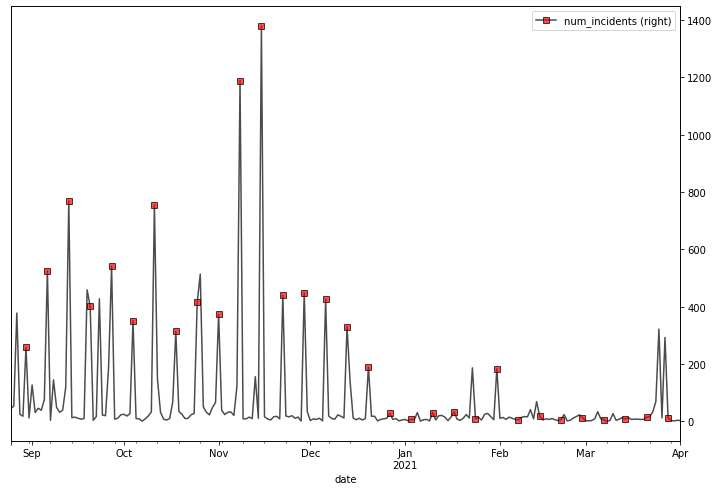

In [32]:
ax1 = df_merge.loc[10:].plot(
    x="date", 
    y="num_prisoners",
    figsize=(12,8),
    style='s-',
    color="black", 
    mfc = "red",  
    alpha=0.7,  
    markevery = np.where(df_merge["day_of_week"].loc[10:] == "Sunday", True, False)
    )

df_merge.loc[10:].plot(
    x="date", 
    y="num_incidents",
    figsize=(12,8),
    style='s-', 
    color="black", 
    mfc = "red",   
    alpha=0.7, 
    secondary_y=True,
    markevery = np.where(df_merge["day_of_week"].loc[10:] == "Sunday", True, False),
    )



In [33]:
df_merge.sort_values(by="num_incidents", ascending=False).head(10)

,date,num_prisoners,num_incidents,day_of_week
92,2020-11-15,4.0,1379.0,Sunday
85,2020-11-08,0.0,1189.0,Sunday
29,2020-09-13,6.0,769.0,Sunday
57,2020-10-11,0.0,755.0,Sunday
43,2020-09-27,8.0,541.0,Sunday
22,2020-09-06,2.0,526.0,Sunday
72,2020-10-26,1.0,514.0,Monday
35,2020-09-19,2.0,459.0,Saturday
106,2020-11-29,0.0,449.0,Sunday
99,2020-11-22,4.0,440.0,Sunday


In [32]:
# save data
f_name = "viasna_dailyCounts_Aug_March.csv"
path = os.path.join(Config.proccessed_data_dir, Config.viasna_data_subdir, f_name)
df_merge.to_csv(path, index=False)

In [ ]:
# create date time 
# filter by date
#incedents.court.value_counts().reset_index().to_csv("../processed_data/viasna_data/court_names.csv", index=False)
#incedents.to_csv("../processed_data/viasna_data/persecutionDatabase_copy.csv")

# groupby district 
#daily_incedents20 = incedents.groupby(["district", "date_of_incident"]).size().unstack(level=0, fill_value=0)
#daily_incedents20.plot(subplots=True, layout=(5, 4), figsize=(20,8))

#prisoners_date_filt = (prisoners.date_of_detention >= min_date) & (prisoners.date_of_detention <= max_date)
#prisoners_filt = prisoners.loc[prisoners_date_filt, :]



In [ ]:
# https://apnews.com/article/belarus-alexander-lukashenko-minsk-archive-elections-038f05df4d1fa275e648acc624467171
# detention v/s arrests: https://www.thomasianlaw.com/blog/2022/september/what-s-the-difference-between-a-detention-and-an/
# Detainment may lead to arrest
